Different learning rates impact how a model learns.

High learning rates will make a model learn faster, but is prone to getting 'stuck' before loss is at a good minimum.

You will see a high loss train, then bounce around once it gets stuck in a valley.

A lower loss is less prone to this issue, but is slower and is more susceptible to local minima.

Learning rates are a tunable parameter, and can even change while training a model. Optimizers can scale learning rates during training based on explored gradients, this is what makes optimizers like Adam usually faster+better than SGD.

In [12]:
import torch
import torch.nn as nn

In [13]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [14]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

In [33]:
import typing


def train_loop(model: torch.nn.Module, optimizer: torch.optim.Optimizer, loss_fn, X_train: torch.Tensor=X_train, y_train: torch.Tensor=y_train,
                        X_test: torch.Tensor=X_test, y_test: torch.Tensor=y_test) -> typing.List[float]:
  # Set the number of epochs (how many times the model will pass over the training data)
  epochs = 20000
  train_loss = []

  for epoch in range(epochs):
      ### Training

      # Put model in training mode (this is the default state of a model)
      model.train()

      # 1. Forward pass on train data using the forward() method inside 
      y_pred = model(X_train)
      # print(y_pred)

      # 2. Calculate the loss (how different are our models predictions to the ground truth)
      loss = loss_fn(y_pred, y_train)
      train_loss.append(loss.item())  # <- store the loss value for later

      # 3. Zero grad of the optimizer
      optimizer.zero_grad()

      # 4. Loss backwards
      loss.backward()

      # 5. Progress the optimizer
      optimizer.step()

      ### Testing

      # Put the model in evaluation mode
      model.eval()

  return train_loss

In [30]:
def build_model(learning_rate: float) -> typing.Tuple[torch.nn.Module, torch.optim.Optimizer, torch.nn.Module]:

    # Set manual seed since nn.Parameter are randomly initialized
    torch.manual_seed(42)

    # Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
    model = LinearRegressionModel()
    # Create the loss function
    loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

    # Create the optimizer
    optimizer = torch.optim.SGD(params=model.parameters(), # parameters of target model to optimize
                                lr=learning_rate) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))
    return model, optimizer, loss_fn

In [34]:
model, optimizer, loss_fn = build_model(learning_rate=0.01)
lr_01_loss = train_loop(model=model, optimizer=optimizer, loss_fn=loss_fn)

model, optimizer, loss_fn = build_model(learning_rate=0.001)
lr_001_loss = train_loop(model=model, optimizer=optimizer, loss_fn=loss_fn)

model, optimizer, loss_fn = build_model(learning_rate=0.0001)
lr_0001_loss = train_loop(model=model, optimizer=optimizer, loss_fn=loss_fn)

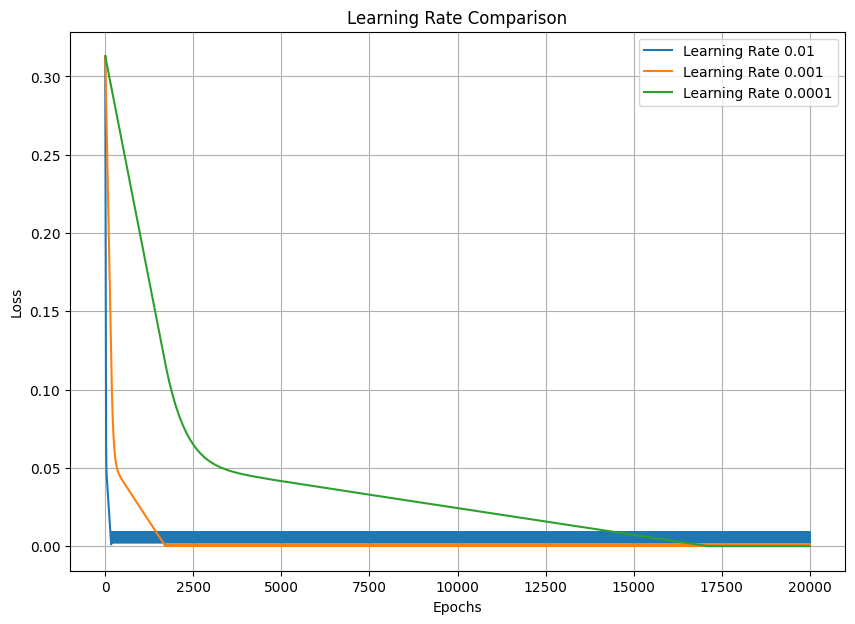

Final Loss with Learning Rate 0.01: 0.0025885067880153656
Final Loss with Learning Rate 0.001: 0.0007075972971506417
Final Loss with Learning Rate 0.0001: 4.9401820433558896e-05


In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.plot(lr_01_loss, label="Learning Rate 0.01")
plt.plot(lr_001_loss, label="Learning Rate 0.001")
plt.plot(lr_0001_loss, label="Learning Rate 0.0001")
plt.title("Learning Rate Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()
print("Final Loss with Learning Rate 0.01:", lr_01_loss[-1])
print("Final Loss with Learning Rate 0.001:", lr_001_loss[-1])
print("Final Loss with Learning Rate 0.0001:", lr_0001_loss[-1])

It can be a bit hard to see, but notice a couple things.
1. The largest learning rate hits it's minimum the fastest, but the thick line is caused by it bouncing back and forth between two losses.
2. The lower the LR for this problem, the better the final loss